In [8]:
# Imports
import pandas as pd

from data_adapters.deribit_adapters import read_parquet  # -> [`data_adapters.deribit_adapters.read_parquet`](data_adapters/deribit_adapters.py)
from config import Algo1Config, DecoderKind               # -> [`config.Algo1Config`](config.py), [`config.DecoderKind`](config.py)
from pipeline.algo1 import run_algo1_deribit  

In [9]:
# Load your raw Deribit parquet
data_path = "/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet"  # change me
df_raw = read_parquet(data_path)

# Configure and run
cfg = Algo1Config(
    n_tau=5,
    n_m=5,
    top_K=50,
    decoder=DecoderKind.HINGE_STATIC,  # or DecoderKind.PLS / DecoderKind.DEEP_PLS
    dda=1,
    dst=1,
    n_sa=1,
    seed=0,
    n_PC_sa=15,
    lam_hinge=1.0
)

outs = run_algo1_deribit(df_raw, cfg, reference_date="2025-01-30", r=0.0, q=0.0)  # [`pipeline.algo1.Algo1Outputs`](pipeline/algo1.py)

# Quick checks
print("C_train shape:", outs.C_train.shape)
print("C_test  shape:", outs.C_test.shape)
print("Vega Weighted MAPE train/test:", outs.VW_MAPE_train, outs.VW_MAPE_test)
print("PSAS train/test:", outs.PSAS_train, outs.PSAS_test)

/Users/arjunshah/Documents/UTS/Thesis/deribit-market-model/data_adapters/deribit_adapters.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Users/arjunshah/Documents/UTS/Thesis/deribit-market-model/surfaces/derivatives.py:21: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  spline = SmoothBivariateSpline(τs, ms, Carr[t], kx=k_tau, ky=k_m, s=s)


C_train shape: (9404, 24)
C_test  shape: (2351, 24)
Vega Weighted MAPE train/test: 0.12117456657869013 0.13615401945531486
PSAS train/test: 0.004572522330922979 0.004678860059549095


In [12]:
from pathlib import Path
import joblib

out_dir = Path("outputs/artifacts")
out_dir.mkdir(parents = True, exist_ok = True)

joblib.dump(outs, out_dir /"algo1_outs.pkl")



['outputs/artifacts/algo1_outs.pkl']

/Users/arjunshah/Documents/UTS/Thesis/deribit-market-model/utils/visuals.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


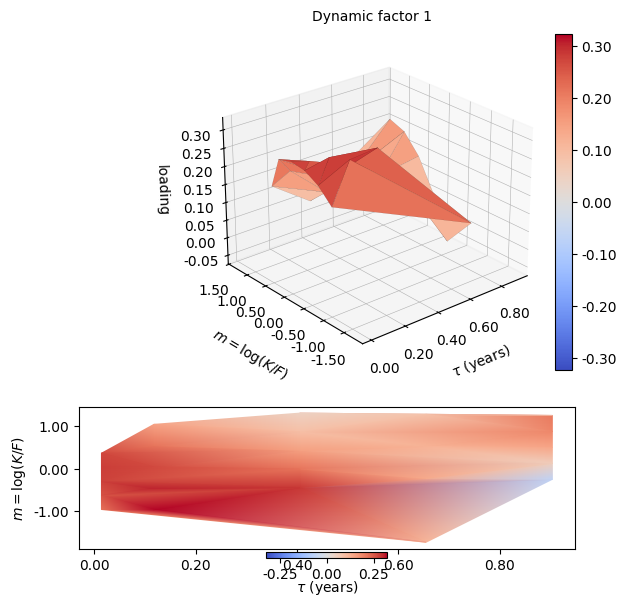

/Users/arjunshah/Documents/UTS/Thesis/deribit-market-model/utils/visuals.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


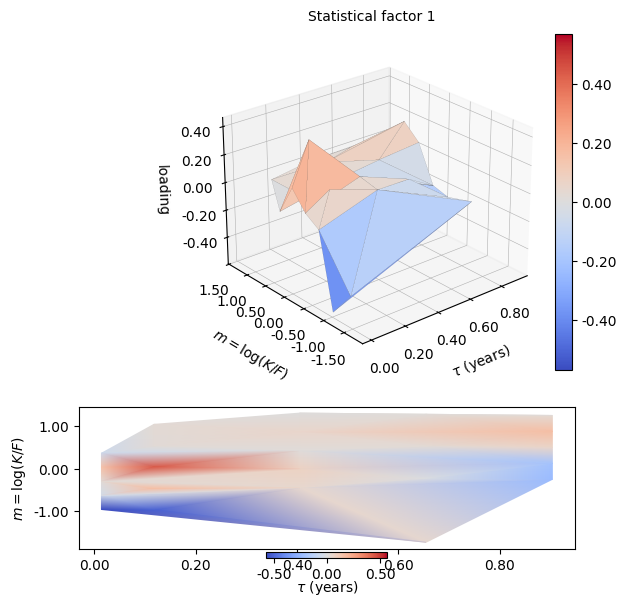

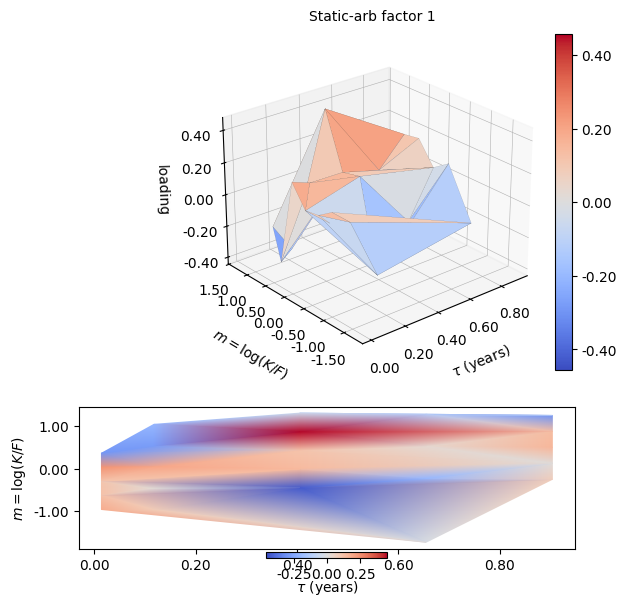

In [10]:
from utils.visuals import plot_factors_figure_731_style
# ===== Example usage once you have `out` from algorithm1_pipeline =====
plot_factors_figure_731_style(outs,
    which=("dyn","stat","sa"),
    elev=25, azim=230,              # camera angles; tweak if you need to match 1:1
    cmap="coolwarm",                # paper-like diverging colormap
    with_heatmaps=True,
    save_prefix="decoded"            # writes PNGs next to your script
)

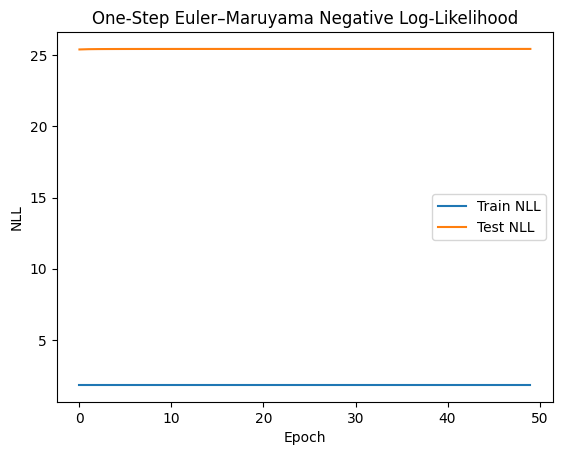

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

In [9]:
import numpy as np
def build_xi_training_data(out, use_dyn = True, use_sa = True, use_stat = True):
    parts = []
    names = []

    if use_dyn and out.Xi_dyn_train.size:
        parts.append(out.Xi_dyn_train); names += [f"dyn{j}" for j in range(out.Xi_dyn_train.shape[1])]
    if use_stat and out.Xi_stat_train.size:
        parts.append(out.Xi_stat_train); names += [f"stat{j}" for j in range(out.Xi_stat_train.shape[1])]
    if use_sa and out.Xi_sa_train.size:
        parts.append(out.Xi_sa_train);   names += [f"sa{j}" for j in range(out.Xi_sa_train.shape[1])]
    X_train = np.concatenate(parts, axis=1) if parts else None

    parts_t = []
    if use_dyn and out.Xi_dyn_test.size:
        parts_t.append(out.Xi_dyn_test)
    if use_stat and out.Xi_stat_test.size:
        parts_t.append(out.Xi_stat_test)
    if use_sa and out.Xi_sa_test.size:
        parts_t.append(out.Xi_sa_test)
    X_test = np.concatenate(parts_t, axis=1) if parts_t else None

    return X_train, X_test, names


X_train, X_test, names = build_xi_training_data(outs)

X_test

array([[ 0.0808617 ,  0.02802978, -0.02604493],
       [ 0.06680447,  0.04818862, -0.01545924],
       [ 0.06419385,  0.05193242, -0.01349332],
       ...,
       [-0.01463799, -0.03264619,  0.01936385],
       [-0.02244146, -0.03241801,  0.02215527],
       [-0.03774791, -0.02747119,  0.02650616]], shape=(2351, 3))